# Image Transformation

The reason for this notebook is two fold. Firstly, in the Tiny 4WD project, one will need to correct the image from the camera at the front. As the camera is close to the floor, objects in the foreground are not in perspective with the background. Therefore understanding image transformation will be key in understanding how to apply correction in the form of projection transformation.

This code aims to apply an affine transformation to an image from the web. Affine transformations include, and are not limited to simple shear, rotation and translation. We will do this using first principles of matrix transformation matrices and vectors. Later we will do the same using the PIL and openCV libraries, which are much faster and less labourous.

Grounds for such a labourous method, brings us to the second reason for this notebook. Learning to apply image transformations is the perfect test of several aspects of what I have learnt in the past months, especially from the Imperial Maths for Machine learning course on Coursera. These are:

1. Linear algebra in the form of Matrix manipulation.
2. Nearest neighbour algoriths.
3. Vector transformations
4. Numpy and general python skills
5. Jupyter notebooks and Latex.

With that said, let us begin! First, import the required libraries.

In [20]:
import requests
from io import BytesIO
from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import math
import time
import timeit

## Preparing the image

Now we need to get the image from a website. For this exercise we use the Olympic Rings. We get the file, convert it to grayscale, and then print it out.

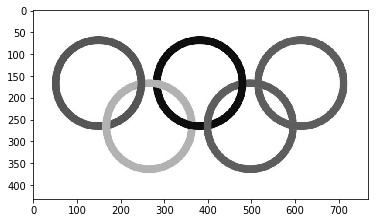

In [3]:
# define the url of the image of interest and download the image
url = "https://jdrhawkins.files.wordpress.com/2018/02/iocrings.jpg?w=768"
response = requests.get(url)

# open the image, and convert to grayscale
raw_img = Image.open(BytesIO(response.content)).convert('LA')

# make image into a numpy array, strip out only the 1st layer
img = np.array(raw_img)[:,:,0]

# make sure that we are plotting inline
%matplotlib inline

# make a function for plotting the images
def plotimg(img):
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.show()

# plot the image to make sure we have something sensible
plotimg(img)

To transform the image we have to start by thinking about the shape that its presented in. Lets begin by examining the shape of the numpy matrix we have. 

In [4]:
img.shape

(432, 768)

For the image above, the x and y coordinates of pixels, are the column and row number respectively. Here we have an image of 432 pixels high (ymax) and 768 pixels wide (xmax). To best transform the image, we convert each pixel in the image to a vector. The vector is representing the image pixel in "Homogeneous coordinates", which is a convenient coordinate system to represent many useful transformations. For the ${n}^{th}$ pixel, the vector is written in the form:

\begin{equation*}
\begin{bmatrix}
x_{n}\\
y_{n} \\
1 \\
p_{n}
\end{bmatrix}
\end{equation*}

where ${p}$ is the colour value of the cell, ${x}$ the column number and ${y}$ the row number. The resulting data for all the pixels is a matrix, 4 rows by ${N}$ columns, where ${N}$ the total number of pixels. 

\begin{equation*}
\mathbf{P} =\begin{bmatrix}
x_{1} & ... & x_{N}\\
y_{1} & ... & y_{N}\\
1 & ... & 1\\
p_{1} & ... & p_{N}
\end{bmatrix}
\end{equation*}


In [5]:
# get out the maximum number of pixels in x and y direction
ymax, xmax = img.shape

# get the total number of pixels N
N = ymax * xmax

# create an empty matrix for the for of 4 rows and N columns
img_matrix = np.empty((4, N))

# introduce the index, which is subscript n in the vector in the text above
index = 0

# now cycle through the full images to fill [x, y, 1, p]^T
for i in list(range(ymax)): # cycle through each row
    for j in list(range(xmax)): # cycle through each column
        p = img[i,j] # extract pixel intensity
        img_matrix[3,index] = p
        img_matrix[2,index] = 1
        img_matrix[1,index] = i # y-cord.
        img_matrix[0,index] = j # x-cord.
        index += 1

img_matrix.shape

(4, 331776)

We also have to have a way of getting the image back to a form that can be plotted. This means converting back to the form that matplotlib can plot - a numpy array where the rows and columns are the x and y coordinates. However, it should be noted, that this way we loose the ability to see the effect of translation.

In [6]:
def imagereform(img_matrix):
    # extract the shape of the matrix
    a, N = img_matrix.shape
    
    # get a list of the maximum and minimum values in each of the rows
    max_in_rows = np.amax(img_matrix, axis=1)
    min_in_rows = np.amin(img_matrix, axis=1)
    
    # get the max and min for x and y
    y_max = int(round(max_in_rows[1]))
    y_min = int(round(min_in_rows[1]))
    x_max = int(round(max_in_rows[0]))
    x_min = int(round(min_in_rows[0]))
    
    # get the span of x and y
    y_lim = y_max - y_min
    x_lim = x_max - x_min
    
    # create an empty array full of NaN values for the image
    img = np.empty((y_lim + 1, x_lim + 1))
    img[:] = np.nan
    
    # cycle through each pixel in the image
    for i in list(range(N)):
        # x and y coordinates, but subtract min value to make sure no negative numbers
        # numpy can not deal with negative indices for rows and columns
        x = int(round(img_matrix[0, i])) - x_min
        y = int(round(img_matrix[1, i])) - y_min
        # upate the image matrix with the pixel intensity
        img[y, x] = img_matrix[3, i]
    
    return img
    

## Transformation from first principles

### Theory

With the image now represented in a matrix containing the (x,y) coordinates, we can being to transform the image. We need to develop some transformation matrices for translation, shear and rotation.

The first is rotation, which we take as a rotation of ${\theta}$ degrees anti clockwise about the origin. Thus we have: 

\begin{equation*}
\mathbf{T}_{rot}  =  \begin{bmatrix}
\cos{\theta} & -\sin{\theta} & 0 & 0\\
\sin{\theta} & cos{\theta} & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}
\end{equation*}

The second is translation, which we take as a shift ${t}_x$ in the positive x direction, a ${t}_y$ in the positive y direction. Thus we have:

\begin{equation*}
\mathbf{T}_{trans}  =  \begin{bmatrix}
1 & 0 & {t}_x & 0 \\
0 & 1 & {t}_y & 0 \\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}
\end{equation*}

Finally we have shear, which is a ${sh}_x$ and ${sh}_y$

\begin{equation*}
\mathbf{T}_{shear}  =  \begin{bmatrix}
1 & {sh}_x & 0 & 0\\
{sh}_y & 1 & 0 & 0 \\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}
\end{equation*}

We can combine transforms by multiplication, where we have the total as:

\begin{equation*}
\mathbf{T}_{total}  =  \mathbf{T}_{rot} . \mathbf{T}_{trans} . \mathbf{T}_{shear}
\end{equation*}

Thus to finally get an image that has been transformed, we multiply the transformation matrix by the image matrix:

\begin{equation*}
\mathbf{P'}  =  \mathbf{T}_{total} . \mathbf{P}
\end{equation*}



### Implementation

So we make some functions to do the rotations, translations and shears

In [7]:
def Trotation(theta):
    # convert theta in degrees to radians
    theta_rad = math.radians(theta)
    T_rot = np.array([[math.cos(theta_rad), -math.sin(theta_rad), 0, 0],
                      [math.sin(theta_rad), math.cos(theta_rad), 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])
    return T_rot

def Tshear(sh_x, sh_y):
    T_shear = np.array([[1, sh_x, 0, 0],
                        [sh_y, 1, 0, 0],
                        [0, 0, 1, 0],
                        [0, 0, 0, 1]])    
    
    return T_shear

def Ttrans(t_x, t_y):
    T_trans = np.array([[1, 0, t_x, 0],
                        [0, 1, t_y, 0],
                        [0, 0, 1, 0],
                        [0, 0, 0, 1]])      
    
    return T_trans

So let us try these and see the results. First we try with a rotation of 45 degrees.

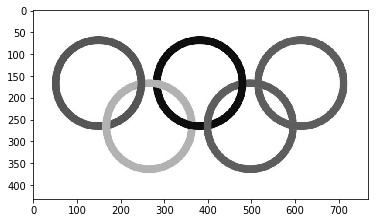

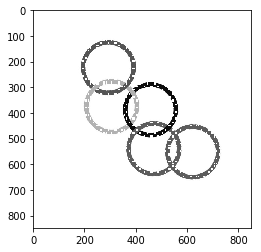

In [8]:
theta = 45

# apply the function to get the transformation matrix
T_rot = Trotation(theta)

# apply the tranformation
trans_rot_img_matrix = T_rot @ img_matrix

# convert the image to nparray form, using function from above
trans_rot_img = imagereform(trans_rot_img_matrix)

# plot the orginal using the plotting function we defined
plotimg(img)

# plot the transfromed image
plotimg(trans_rot_img)

And then a shear in the x and y direction of 0.5

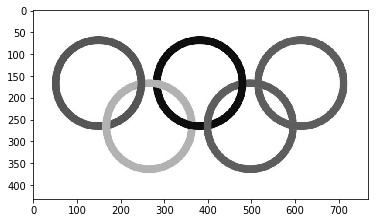

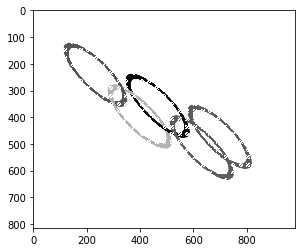

In [9]:
sh_x = 0.5
sh_y = 0.5
T_shear = Tshear(sh_x, sh_y)

trans_shear_img_matrix = T_shear @ img_matrix

trans_shear_img = imagereform(trans_shear_img_matrix)

plotimg(img)
plotimg(trans_shear_img)

while the rotation and shear are done, we still have a problem. Lets have a look in more detail what is going on. Lets zoom into the shear first to look at a 20 by 20 pixel area.

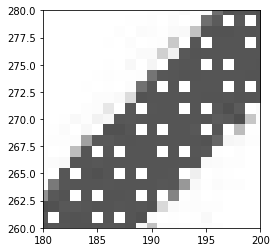

In [87]:
plt.figure()
plt.imshow(trans_shear_img, cmap='gray')
plt.xlim(180, 200)
plt.ylim(260, 280)
plt.show()

And the rotation zoomed into a 20 by 20 pixel area.

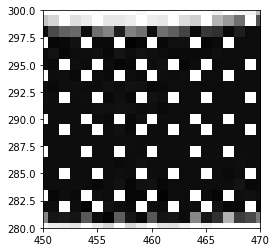

In [88]:
plt.figure()
plt.imshow(trans_rot_img, cmap='gray')
plt.xlim(450, 470)
plt.ylim(280, 300)
plt.show()

The space between the original pixels has not been transformed from the original image. How could they be, they did not exist in the original image. However, when we made the transformation, suddenly the area between has been created, and we need to fill it some how.

## Image correction



### Theory
To understand the correction methods, we first need to visualize the issue. Lets think of a schematic of just 9 pixels on Cartesian coordinates. We create the pixels as boxes, with Cartesian coordinates for each corner. Remember as before, given that we will use our transformation matrix from above, we must have the pixels in homogeneous coordinates i.e in the form as before, but with $p_{n}$ now equal to 1:

\begin{equation*}
\begin{bmatrix}
x_{n}\\
y_{n} \\
1 \\
1
\end{bmatrix}
\end{equation*}


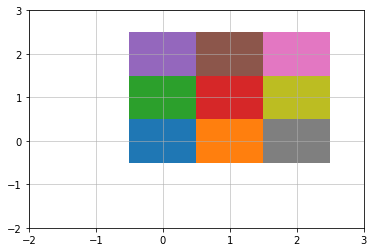

In [11]:
# function generates a list of arrays for the corners of each pixel
def pixelcorners(pix_array):
    # now get the corner co-ordinates
    D, N = pix_array.shape
    corners_list = list()
    for i in list(range(N)):
        corner_array = np.empty((D,5))
        pix_cords = pix_array[:,i]
        # now create the corner co-ordinates, half a pixel from the center)
        corner_array[:,0] = pix_cords + np.array([-0.5, -0.5, 0, 0]) #corner1
        corner_array[:,1] = pix_cords + np.array([ 0.5, -0.5, 0, 0]) #corner2
        corner_array[:,2] = pix_cords + np.array([ 0.5,  0.5, 0, 0]) #corner3
        corner_array[:,3] = pix_cords + np.array([-0.5,  0.5, 0, 0]) #corner4
        corner_array[:,4] = pix_cords + np.array([-0.5, -0.5, 0, 0]) #corner1
        corners_list.append(corner_array)  
    
    return corners_list

# define the centre points for each pixel
pix_array = np.array([[0, 1, 0, 1, 0, 1, 2, 2, 2],
                      [0, 0, 1, 1, 2, 2, 2, 0, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1, 1]])

corners_list = pixelcorners(pix_array)

# set up the plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot them with the area between filled in
for j in list(range(len(corners_list))):
    ax.fill_between(corners_list[j][0,:], corners_list[j][1,:])

# add some grid lines
major_ticks = np.arange(-2, 4, 1)
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)


# Set grid to use minor tick locations. 
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.7)

plt.show()

We can apply the transformation center of each pixel, to see how the pixels center locations, and the corresponding area around them look after a transformation. Here the transformation is a rotation of 45 degrees.

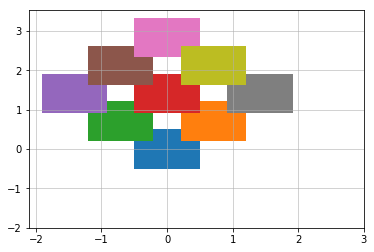

In [12]:
theta = 45

# get the transformation matrix
T_rot = Trotation(theta)

# get the array of transformed pixel centers
pix_array_trans = T_rot @ pix_array

# use the function to extract the transformed corners from the centers
corners_list = pixelcorners(pix_array_trans)

# set up the plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot them with the area between filled in
for j in list(range(len(corners_list))):
    ax.fill_between(corners_list[j][0,:], corners_list[j][1,:])

# add some grid lines
major_ticks = np.arange(-2, 4, 1)
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)


# Set grid to use minor tick locations. 
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.7)

plt.show()

We clearly see the rotation. However, the center of each pixel must be on the intersection of the grid lines, i.e. a pixel coordinates must be integer. Thus we must round the x and y to the nearest integer, as was done above for the images.

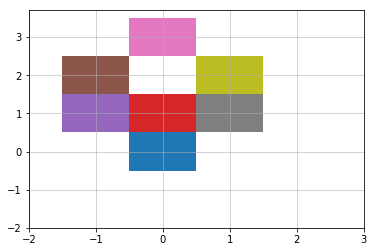

In [13]:
theta = 45
T_rot = Trotation(theta)

pix_array_trans = T_rot @ pix_array

pix_array_trans = np.round(pix_array_trans)

corners_list = pixelcorners(pix_array_trans)

# set up the plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot them with the area between filled in
for j in list(range(len(corners_list))):
    ax.fill_between(corners_list[j][0,:], corners_list[j][1,:])

# add some grid lines
major_ticks = np.arange(-2, 4, 1)
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)


# Set grid to use minor tick locations. 
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.7)

plt.show()

Now we see the problem clearly. There is gap at (0,2), and the green cell at (0,1) in the original image has been overlaid by the purple cell now at (1,-1). The overlay, while not great, is not as bad as the missing pixel. To get this we need to think about what that missing pixel might be. Let us first map the missing pixel in the transformation back to the original space. We do this by applying the inverse of $\mathbf{T}$ to the transformed coordinates:

\begin{equation*}
\begin{bmatrix}
x_{n}\\
y_{n} \\
1 \\
p_{n}
\end{bmatrix}  =  \mathbf{T}^{-1} \begin{bmatrix}
x'_{n}\\
y'_{n} \\
1 \\
p_{n}
\end{bmatrix}
\end{equation*}

Let us see where they are, by making the inverse transformation, and then plotting it on the same set of pixels in the original image. The empty pixel in the transformed image is shown as a blue dot.

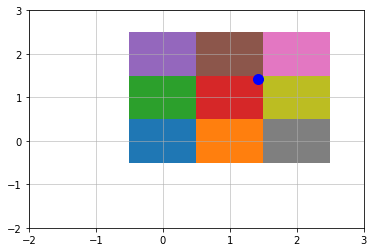

In [14]:
empty_pixel_trans = np.array([[0],
                              [2],
                              [1],
                              [1]])

theta = 45
T_rot = Trotation(theta)

empty_pixel = np.linalg.inv(T_rot) @ empty_pixel_trans

corners_list = pixelcorners(pix_array)

# set up the plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot them with the area between filled in
for j in list(range(len(corners_list))):
    ax.fill_between(corners_list[j][0,:], corners_list[j][1,:])

ax.plot(empty_pixel[0], empty_pixel[1], markersize=10, c='b', marker='o')
# add some grid lines
major_ticks = np.arange(-2, 4, 1)
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)


# Set grid to use minor tick locations. 
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.7)

plt.show()


So now we see that we want we have a number of choices of how to assign the pixel. We can either assign it a value of pixel it resides in, i.e the center pixel. This is easy to do, we simply apply a nearest neighbours approach.

Otherwise we can take an an average of the pixels that surround the dot. Either of the ones immediately around it, i.e the 2x2 pixels which is called Bilinear, or looking at pixels further out, such as 4x4 as Bicubic. There are many others methods, but those are the most commonly used.

For now we will simply do a nearest neighbours approach.


### Implientation of nearest neighbours correction

The first challenge is to find the pixels that are gaps. From the function imagereform(img_matrix) we make the array that is populated by the transformed pixels by NaN. That means that we need to find the NaN values in the area that is bounded by the transformed image.

The area that we will bound is a parallelogram, as the affine operations we have used above preserve lines that are parallel. Say we have parallelogram bounded by A, B, C and D, shown here: 

<img src="http://www.maths.usyd.edu.au/u/MOW/vectors/images/v1124x.gif" />

Thus we can say that the area bounded in the image can be found from the cross product of the vectors defining two adjacent edges. In the figure above, the area $\mathbf{A}_{ABCD}$ would be the blue and white area (ABCD) bounded by the parallelogram:

\begin{equation*}
\mathbf{A}_{ABCD}  = \begin{vmatrix}
\vec{\mathbf{AB}} \times \vec{\mathbf{AC}}
\end{vmatrix}
\end{equation*}

for the blue shaded area of a triangle $\mathbf{A}_{ABC}$ it would be half of the area of the full parallelogram: 

\begin{equation*}
\mathbf{A}_{ABC}  = \frac{1}{2} \begin{vmatrix}
\vec{\mathbf{AB}} \times \vec{\mathbf{AC}}
\end{vmatrix}
\end{equation*}


Thus if we were to have a point X in the bounds of the parallelogram we could say that.

\begin{equation*}
\mathbf{A}_{ABCD}  = \mathbf{A}_{ABX} + \mathbf{A}_{ACX} + \mathbf{A}_{BDX} + \mathbf{A}_{CDX}
\end{equation*}

we can rewrite this as:

\begin{equation*}
\begin{vmatrix} \vec{\mathbf{AB}} \times \vec{\mathbf{AC}} \end{vmatrix}  = 
\frac{1}{2} \begin{vmatrix} \vec{\mathbf{AX}} \times \vec{\mathbf{AB}} \end{vmatrix} +
\frac{1}{2} \begin{vmatrix} \vec{\mathbf{AX}} \times \vec{\mathbf{AC}} \end{vmatrix} +
\frac{1}{2} \begin{vmatrix} \vec{\mathbf{BX}} \times \vec{\mathbf{BD}} \end{vmatrix} +
\frac{1}{2} \begin{vmatrix} \vec{\mathbf{CX}} \times \vec{\mathbf{CD}} \end{vmatrix}
\end{equation*}

If the point X is outside the parallelogram then the statement above will not be true. Thus we need to write a function that calculates if this statement is true. Then we need to find p values with are equal to NaN, and test if they are in the area bounded by the image.


In [15]:
def transimagecorners(img_matrix, T_matrix):
    
    # first determine the corners of the image before transformation
    max_in_rows = np.amax(img_matrix, axis=1)
    min_in_rows = np.amin(img_matrix, axis=1)
    y_max = max_in_rows[1]
    y_min = min_in_rows[1]
    x_max = max_in_rows[0]
    x_min = min_in_rows[0]
    corners_array = np.array([[x_min, x_max, x_max, x_min],
                              [y_min, y_min, y_max, y_max],
                              [1, 1, 1, 1],
                              [1, 1, 1, 1]])
    
    # deterimine the transformed image corners
    trans_corners_array = T_matrix @ corners_array
    
    return trans_corners_array

def inimage(trans_corners_array, pixel_cord):
    
    # find the corners
    corner_A = trans_corners_array[0:2, 0]
    corner_B = trans_corners_array[0:2, 1]
    corner_C = trans_corners_array[0:2, 2]
    corner_D = trans_corners_array[0:2, 3]
    pixel_X = pixel_cord[0:1, 0]
    
    # find the area of the image
    area_image = np.cross((corner_B - corner_A), (corner_C - corner_A))
    
    # find the area of the triangles with X
    area_ABX = 0.5 * np.cross((corner_B - corner_A), (pixel_X - corner_A))
    area_ACX = 0.5 * np.cross((corner_C - corner_A), (pixel_X - corner_A))
    area_BDX = 0.5 * np.cross((corner_D - corner_B), (pixel_X - corner_B))
    area_CDX = 0.5 * np.cross((corner_D - corner_C), (pixel_X - corner_C))
    area_X = area_ABX + area_ACX + area_BDX + area_CDX
    
    if area_image == area_X:
        in_image_bool = True
    else:
        in_image_bool = False
    
    return in_image_bool

Let us set up a test of the functions to see if it works. Find the edges for the rotated image by 45 degrees:

In [16]:
theta = 45
T_rot = Trotation(theta)
trans_corners_array = transimagecorners(img_matrix, T_rot)

print(trans_corners_array)

[[   0.          542.35090117  237.58787848 -304.76302269]
 [   0.          542.35090117  847.11392386  304.76302269]
 [   1.            1.            1.            1.        ]
 [   1.            1.            1.            1.        ]]


We know that at the coordinates (400,400), we have a pixel that is in the image.

In [40]:
test_pixel_trans_1 = np.array([[0],
                             [100],
                             [1],
                             [1]])

print(inimage(trans_corners_array, test_pixel_trans_1))

True


We get the response "True", so we are happy. We can also test a pixel we know is outside the area.

In [38]:
test_pixel_trans_2 = np.array([[500],
                             [100],
                             [1],
                             [1]])

print(inimage(trans_corners_array, test_pixel_trans_2))

False


Great, we get "False"! We get True and False for points we know are in and out respectively. We now need to run through the image and find the missing pixels. However, how efficient is this going to be? We need to see how long it takes.

In [48]:
%time inimage(trans_corners_array, test_pixel_trans_1)
pass

Wall time: 1 ms


In [57]:
#count NaN in trans_rot_img
NaN_pixels = np.count_nonzero(trans_rot_img) - np.count_nonzero(~np.isnan(trans_rot_img))
print("Number of Nan pixels", NaN_pixels)
print(round((1/1000)*NaN_pixels/60), "minutes")

Number of Nan pixels 444253
7 minutes


So about 1 millisecond per cycle, but if we have an image of roughly 700000 pixels we will have to wait for about 7 minutes to get this through each one. Thats too long.

How long does it take if we transform the pixel back to the original image, and if its within the limits of the rectangle we note it down. This does not require multiple cross products, however it is limited to images which are rectangular to begin with.  

In [44]:
def inimage2(img_matrix, T_rot, pixel_cord):
    # first determine the corners of the image before transformation
    max_in_rows = np.amax(img_matrix, axis=1)
    min_in_rows = np.amin(img_matrix, axis=1)
    y_max = max_in_rows[1]
    y_min = min_in_rows[1]
    x_max = max_in_rows[0]
    x_min = min_in_rows[0]
    
    pixel_cord_org = np.linalg.inv(T_rot) @ pixel_cord
    
    pixel_org_x = pixel_cord_org[0]
    pixel_org_y = pixel_cord_org[1]
    if pixel_org_x >= x_min and pixel_org_y >= y_min and pixel_org_x <= x_max and pixel_org_y <= y_max:
        in_image_bool = True
    else:
        in_image_bool = False
    
    return in_image_bool


Test function again on the same two pixels

In [45]:
print("Test Pixel 1", inimage2(img_matrix, T_rot, test_pixel_trans_1))
print("Test Pixel 2", inimage2(img_matrix, T_rot, test_pixel_trans_2))

Test Pixel 1 True
Test Pixel 2 False


We seem to get the correct answers, but how long does it take?

In [47]:
%time inimage2(img_matrix, T_rot, test_pixel_trans_1)
pass

Wall time: 3 ms


Ouch! Even worse, this would take 21 minutes to transfer the image. What if we just make an assumption that if a pixel's neighbours are also NaN, then it is likely to not be in the original image. If the neibour pixels have values then its most likely that its within the original image.

To get a quick estimate, we calculate the sum of the pixels that are surrounding the pixel of interest. We start by adding a padding of zeros around the image. We then check the pixel neighbours to see sum, and if the sum is greater than zero, we assume its in the image. 

Lets see how many that is now.

In [166]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# find the shape of the image
Ylim, Xlim = trans_rot_img.shape

# set how much we want to pad the matrix, and then pad it with zeros
pad_dim = 1
trans_rot_img_pad = np.pad(trans_rot_img, ((pad_dim, pad_dim), (pad_dim, pad_dim)), 'constant')

# set a count for the number of pixels that are NaN in the image, and in total
count = 0
count_nan = 0

# cycle through the image, within the padded image
for x in list(range(pad_dim, Xlim - pad_dim)):
    for y in list(range(pad_dim, Ylim - pad_dim)):
        # check if the value is NaN
        if math.isnan(trans_rot_img_pad[y, x]) is True:
            count_nan += 1
            # grab the surrounding pixels
            pixel_sub = trans_rot_img_pad[y-(pad_dim +1):y+(pad_dim),x-(pad_dim +1):x+(pad_dim)]
            # sum them with nansum, because they will have NaN values
            sumcheck = np.nansum(pixel_sub)
            # iterate count if its non zero
            if sumcheck > 0:
                count += 1
    

print("Number of Nan pixels", count_nan)
print("Number of Nan pixels that need to be tested", count)
print(round((1/1000)*count/60), "minutes")

Number of Nan pixels 440875
Number of Nan pixels that need to be tested 60128
1 minutes


Great, we are now down to about a minute of runtime. Still a while, because the edge pixels are tested, but we have less to worry about.

In [165]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# find the shape of the image
Ylim, Xlim = trans_rot_img.shape

# set how much we want to pad the matrix, and then pad it with zeros
pad_dim = 1
trans_rot_img_pad = np.pad(trans_rot_img, ((pad_dim, pad_dim), (pad_dim, pad_dim)), 'constant')

# set a count for the number of pixels that are NaN in the image, and in total
count = 0
count_nan = 0

# set an array to capture coordinates
missing_pixels = np.empty((4, 0))
missing_pixels[:] = np.nan
# cycle through the image, within the padded image
for x in list(range(pad_dim, Xlim - pad_dim)):
    for y in list(range(pad_dim, Ylim - pad_dim)):
        # check if the value is NaN
        if math.isnan(trans_rot_img_pad[y, x]) is True:
            count_nan += 1
            # grab the surrounding pixels
            pixel_sub = trans_rot_img_pad[y-(pad_dim +1):y+(pad_dim), x-(pad_dim +1):x+(pad_dim)]
            # sum them with nansum, because they will have NaN values
            sumcheck = np.nansum(pixel_sub)
            # iterate count if its non zero
            if sumcheck > 0:
                count += 1
                pixel = np.array([[x],
                                  [y],
                                  [1],
                                  [1]])
                
                # check if its actually in the image or not using the function from before
                if inimage(trans_corners_array, pixel) is True:
                    # append to the array we made earier
                    missing_pixels = np.append(missing_pixels, pixel, axis=1)

print("Number of Nan pixels", count_nan)
print("Number of Nan pixels that need to be tested", count)
print("Number of missing pixels", missing_pixels.shape[1])

Number of Nan pixels 440875
Number of Nan pixels that need to be tested 60128
Number of missing pixels 0


So exactly all the empty pixels we find, are actually in the shape. So we need to find the pixel values, which is done using a nearest neighbour approach.

In [161]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
D, num_missing = missing_pixels.shape

missing_pixels_orgimg = np.linalg.inv(T_rot) @ missing_pixels

for i in list(range(num_missing - 1)):
    missing_pixel_cord = np.around(missing_pixels_orgimg[:,i])
    missing_pixel_intensity = img[int(missing_pixel_cord[1]), int(missing_pixel_cord[0])]
    missing_pixels[3,i] = missing_pixel_intensity
    
# convert the image to nparray form, using function from above
missing_pixels_img = imagereform(trans_rot_img_matrix)

# plot the orginal using the plotting function we defined
plotimg(img)

# plot the transfromed image
plotimg(trans_rot_img)
    

(432, 768)
985.7068529740473
